## Data preparation

### Uploading data

In order to achieve the objective that the company has set for us, we actually need to first take a look at the data that we have been provided with. Thus, let's import all libraries, functions and data structures which will be particularly useful for completing the project. 

Additionally, we will define some constant variables, the values of which will be fixed:

* `RANDOM_STATE` (calibrating the random number generator for reproducibility); 
* `CV_FOLDS` (setting the number of folds to be used in cross-validation);
* `MAX_DEPTH`, `FOREST_MAX_DEPTH` (the highest values of `max_depth` hyperparameter to consider in hyperparameter tuning for Decision Tree and Random Forest models, respectively);
* `FOREST_SIZE_START`, `FOREST_SIZE_END`, `FOREST_SIZE_STEP` (fixing the values of `n_estimators` hyperparameter to consider in hyperparameter tuning for Random Forest model).

We will also set the visual theme for the plots via `sns.set_theme()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

from typing import Union

# Defining constants
RANDOM_STATE = 12345
CV_FOLDS = 3
MAX_DEPTH = 10
FOREST_SIZE_START = 10
FOREST_SIZE_END = 20
FOREST_SIZE_STEP = 10
FOREST_MAX_DEPTH = 3

# Setting a visual theme for plots
sns.set_theme(style="darkgrid")

Now, let's load the data contained in each *csv*-file into a separate DataFrame. As stated in the project description, the data is to be indexed by the date and time of obtaining information so we will use `date` feature as an index, thus specifying `index_col="date"` and simulataneously converting it to *datetime* using `parse_dates=True`.

In [2]:
gold_recovery_train = pd.read_csv(
    "gold_recovery_train_new.csv", index_col="date", parse_dates=True
)
gold_recovery_test = pd.read_csv(
    "gold_recovery_test_new.csv", index_col="date", parse_dates=True
)
gold_recovery_full = pd.read_csv(
    "gold_recovery_full_new.csv", index_col="date", parse_dates=True
)

We see that we have now three DataFrames for each of the files provided:

* `gold_recovery_train` => training set;
* `gold_recovery_test` => test set;
* `gold_recovery_full` => full data.

### Data overview

Let's look at the data contained in these DataFrames and print the first five rows of each one.

In [3]:
gold_recovery_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
gold_recovery_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
gold_recovery_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


We notice a fairly large number of columns in all DataFrames and looking at these small samples of 5 observations in each, it is difficult to say anything specific about the data at hand. Let's use `info()` method to get a concise summary of the data, namely, information on column names, data types and the number of `non-null` values in each of the columns.

In [6]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [7]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [8]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

In [9]:
# Verifying the correctness of data split
assert (
    gold_recovery_train.shape[0] + gold_recovery_test.shape[0]
    == gold_recovery_full.shape[0]
)

We can see that the original data from `gold_recovery_full` DataFrame has been divided into training and test sets correctly. Furthermore, the columns for all DataFrames are characterized by the same `float64` data type so there are no problems with data types. We can also notice that many columns have a certain number of missing values, which we will have to deal with at the data preprocessing stage.

Now let's take a closer look at the column names. It can be seen that these represent three certain words (blocks) that are separated by dots. In fact the names have a specific structure as well as meaning. Take, for instance, a column called `final.output.concentrate_au` and consider what its name is made up of: 

$$
\underbrace{final}_\text{[stage]}.\underbrace{output}_\text{[parameter_type]}.\underbrace{concentrate\_au}_\text{[parameter_name]}
$$

It can be seen that the name starts with a stage of the gold recovery process (`final`). Second, we see the type of the parameter (`output`). Lastly, there is a description of a certain parameter used in the recovery process (`concentrate_au`). 

These three blocks can take multiple different values as seen from the column names printed out above so let's consider all columns and find out what values each of these blocks can take. To do this, we can simply separate the column names by dots and display all possible unique values in each of these three blocks. This can be done using the `print_separated_column_names()` function, which we will write below.

In [10]:
def print_separated_column_names(
    data: pd.DataFrame,
    separator: str = ".",
    include_unique_values: bool = True,
    show_stage_names: bool = False,
    show_parameter_types: bool = False,
    show_parameter_names: bool = False,
) -> None:
    """Splits column names of a DataFrame by a separator
    and prints the results.

    Column names are split into three words assigned to distinct
    three blocks according to the separator passed, and their unique
    values (by default) are then printed out by blocks.

    Args:
        data: DataFrame with gold-bearing ore extraction and
            purification parameters.
        separator: Column names separator.
            [default: {"."}]
        include_unique_values: Boolean value indicating including
            only unique values in each block.
            [default: {True}]
        show_stage_names: Boolean value indicating showing possible
            names of stages of gold purification process.
            [default: {False}]
        show_parameter_types: Boolean value indicating showing possible
            types of parameters of gold purification process.
            [default: {False}]
        show_parameter_names: Boolean value indicating showing possible
            names of parameters of gold purification process.
            [default: {False}]

    Returns:
        Returns nothing. Prints out possible names contained in blocks
        and retrieved from DataFrame columns in accordance with the
        separator.
    """
    # Defining blocks to store column name separation results
    stage_names = []
    parameter_types = []
    parameter_names = []

    # Splitting column names by separator
    for column in data.columns:
        column_names_splitted = column.split(separator)

        stage_names.append(column_names_splitted[0])
        parameter_types.append(column_names_splitted[1])
        parameter_names.append(column_names_splitted[2])

    # Including only unique values in each block
    if include_unique_values:
        stage_names = set(stage_names)
        parameter_types = set(parameter_types)
        parameter_names = set(parameter_names)

    # Printing out separated column names
    if show_stage_names:
        print("Possible values in [stage] block:")
        for i, sep_value in enumerate(sorted(stage_names)):
            print(f"{i+1}. {sep_value}")
    if show_parameter_types:
        print("Possible values in [parameter_type] block:")
        for i, sep_value in enumerate(sorted(parameter_types)):
            print(f"{i+1}. {sep_value}")
    if show_parameter_names:
        print("Possible values in [parameter_name] block:")
        for i, sep_value in enumerate(sorted(parameter_names)):
            print(f"{i+1}. {sep_value}")

Let's apply this function to the DataFrame with full information (`gold_recovery_full`) and consider each block.

In [11]:
# Printing possible stage names
print_separated_column_names(data=gold_recovery_full, show_stage_names=True)

Possible values in [stage] block:
1. final
2. primary_cleaner
3. rougher
4. secondary_cleaner


In [12]:
# Printing possible parameter types
print_separated_column_names(data=gold_recovery_full, show_parameter_types=True)

Possible values in [parameter_type] block:
1. calculation
2. input
3. output
4. state


In [13]:
# Printing possible parameter names
print_separated_column_names(data=gold_recovery_full, show_parameter_names=True)

Possible values in [parameter_name] block:
1. au_pb_ratio
2. concentrate_ag
3. concentrate_au
4. concentrate_pb
5. concentrate_sol
6. depressant
7. feed_ag
8. feed_au
9. feed_pb
10. feed_rate
11. feed_size
12. feed_sol
13. floatbank10_a_air
14. floatbank10_a_level
15. floatbank10_b_air
16. floatbank10_b_level
17. floatbank10_c_air
18. floatbank10_c_level
19. floatbank10_d_air
20. floatbank10_d_level
21. floatbank10_e_air
22. floatbank10_e_level
23. floatbank10_f_air
24. floatbank10_f_level
25. floatbank10_sulfate
26. floatbank10_sulfate_to_au_feed
27. floatbank10_xanthate
28. floatbank11_sulfate
29. floatbank11_sulfate_to_au_feed
30. floatbank11_xanthate
31. floatbank2_a_air
32. floatbank2_a_level
33. floatbank2_b_air
34. floatbank2_b_level
35. floatbank3_a_air
36. floatbank3_a_level
37. floatbank3_b_air
38. floatbank3_b_level
39. floatbank4_a_air
40. floatbank4_a_level
41. floatbank4_b_air
42. floatbank4_b_level
43. floatbank5_a_air
44. floatbank5_a_level
45. floatbank5_b_air
46. floa

We see that the first block containing names of the stages of gold purification process has four unique values:

* `final`: final characteristics;
* `primary_cleaner`: primary purification;
* `rougher`: flotation;
* `secondary_cleaner`: secondary purification.

Let's now consider what parameter types there are in the process:

* `calculation`: calculated characteristics;
* `input`: input parameters;
* `output`: output parameters;
* `state`: current stage state characteristics.

The last block with parameter names contains a wide range of possible values. We will not describe each of them, since not all of them will be particularly relevant to us during completing this project. Nevertheless, we will later pay a particular attention to some of them.  

### Computing gold recovery efficiency

Now, let's compute gold recovery efficiency and verify if it has been calculated correctly. It is important, since this will be one of the targets that we need to predict. Gold recovery efficiency can be computed as follows:

$$
Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%,
$$
where $C$ - proportion of gold in concentrate after flotation/purification, $F$ - proportion of gold in input/concentrate before flotation/purification, а $T$ - proportion of gold in tails after flotation/purification. 

Basically, all we need to understand to compute this indicator is which columns of `gold_recovery_full` represent the parameters ($C$, $F$, $T$) of the above formula. We can then check whether gold recovery was calculated correctly, which is contained in `rougher.output.recovery` column. In this case, the information we need is contained in the following columns:

* `rougher.output.concentrate_au` => $C$ parameter;

* `rougher.input.feed_au` => $F$ parameter;

* `rougher.output.tail_au` => $T$ parameter.

This allows us to write a function called `compute_gold_recovery_efficiency()` that we will define below.

In [14]:
def compute_gold_recovery_efficiency(data: pd.DataFrame) -> float:
    """Computes efficiency of gold recovery as a percentage.

    It is assumed that a function will be applied to the entire
    DataFrame using 'apply()' method, where, given data for each row
    of the columns chosen, indicator will be computed.

    Args:
        data: DataFrame with gold-bearing ore extraction and
            purification parameters.

    Returns:
        Floating point number computed in percent which is
        essentially the value of gold recovery efficiency.
    """
    # Selecting data for computing gold recovery
    C = data["rougher.output.concentrate_au"]
    F = data["rougher.input.feed_au"]
    T = data["rougher.output.tail_au"]

    # Computing gold recovery efficiency
    recovery = (C * (F - T)) / (F * (C - T)) * 100

    return recovery

Now, we can compute gold recovery efficiency using `apply()` method, the result of which we will store in a new column called `rougher.output.recovery_computed`.

In [15]:
gold_recovery_full["rougher.output.recovery_computed"] = gold_recovery_full.apply(
    compute_gold_recovery_efficiency, axis=1
)

We can verify whether we have correctly computed this indicator by comparing the results with the values of gold recovery already computed beforehand and available in `rougher.output.recovery` column. This can be done by calculating *Mean Absolute Error (MAE)* metric with its arguments being values in `rougher.output.recovery_computed` and `rougher.output.recovery` columns.

In [16]:
# Computing MAE
mae_gold_recovery = mean_absolute_error(
    gold_recovery_full["rougher.output.recovery_computed"],
    gold_recovery_full["rougher.output.recovery"],
)

# Verifying the correctness of computations
assert (
    np.round(mae_gold_recovery) == 0
), "Incorrect gold recovery efficiency calculation"

# Printing out MAE value
print("MAE: {}".format(mae_gold_recovery))

MAE: 9.874045668302637e-15


We see that the value of the metric proved to be extremely small, thus showcasing the fact that we have computed gold recovery correctly and proving that the values in `rougher.output.recovery` have been computed correctly. Hence, let's drop a column with the computed gold recovery from our data and move on. 

In [17]:
gold_recovery_full.drop("rougher.output.recovery_computed", axis=1, inplace=True)

### Features analysis

As written in the project description, there are some features that are present in full data (`gold_recovery_full`) but absent in test set (`gold_recovery_test`). Thus, let's take a look at what features are not accessible to the test set.

In [18]:
gold_recovery_full_columns = gold_recovery_full.columns
gold_recovery_test_columns = gold_recovery_test.columns

# Identifying columns inaccessible to test set
columns_test_inaccessible = []
for column in gold_recovery_full_columns:
    if column not in gold_recovery_test_columns:
        columns_test_inaccessible.append(column)

Let's choose such columns from our full data in order to apply previously written `print_separated_column_names()` function so as to study what peculiarities inaccessible columns have.

In [19]:
print_separated_column_names(
    data=gold_recovery_full[columns_test_inaccessible], show_stage_names=True
)

Possible values in [stage] block:
1. final
2. primary_cleaner
3. rougher
4. secondary_cleaner


In [20]:
print_separated_column_names(
    data=gold_recovery_full[columns_test_inaccessible], show_parameter_types=True
)

Possible values in [parameter_type] block:
1. calculation
2. output


In [21]:
print_separated_column_names(
    data=gold_recovery_full[columns_test_inaccessible], show_parameter_names=True
)

Possible values in [parameter_name] block:
1. au_pb_ratio
2. concentrate_ag
3. concentrate_au
4. concentrate_pb
5. concentrate_sol
6. floatbank10_sulfate_to_au_feed
7. floatbank11_sulfate_to_au_feed
8. recovery
9. sulfate_to_au_concentrate
10. tail_ag
11. tail_au
12. tail_pb
13. tail_sol


Now, we can see the structure of the column names for those columns that are absent in the test set. It is quite noticeable that calculation (`calculation`) and output (`output`) characteristics of the process are not available, because they cannot be obtained or measured during the execution of the technological process. Conversely, such parameters are computed and measured much later. Moreover, we notice that parameter names contain `recovery` meaning that the test set does not contain our target that will have to be dealt with later.

### Data preprocessing

#### Missing values

Let's look at the missing values in each of the three DataFrames. To do this, we can write `identify_missing_values()` function, which will output the names of columns in which there are missing values, as well as the number and proportion of missing values in them.

In [22]:
def identify_missing_values(
    data: pd.DataFrame, include_missing_fraction=False
) -> Union[pd.DataFrame, None]:
    """Computes a number and share of missing values
    in DataFrame columns which have NaN-values present.

    Args:
        data: DataFrame with gold-bearing ore extraction and
            purification parameters.
        include_missing_fraction: Boolean value indicating including
            shares of missing values in the output results.
            [default: {False}]

    Returns:
        DataFrame with column names, number of missing values
        and shares of NaN-values in such columns. In case there
        are not missing values present, an according message is
        shown and nothing will be returned.
    """
    # Verifying missing values
    miss_vals_num = data.isnull().sum()[data.isnull().sum() > 0]
    if miss_vals_num.empty == True:
        print("Missing values are not found.")
        return
    # Creating a table with numbers of missing values
    cols = {"missing_count": miss_vals_num.values}
    nans_df = pd.DataFrame(data=cols, index=miss_vals_num.index).sort_values(
        by="missing_count", ascending=False
    )
    # Adding shares of missing values
    if include_missing_fraction:
        nans_df["missing_fraction"] = nans_df["missing_count"] / data.shape[0]
        nans_df["missing_fraction"] = nans_df["missing_fraction"].round(4)

    return nans_df

Let's apply this function to each DataFrame in order to see how serious missing values problem is.

In [23]:
identify_missing_values(data=gold_recovery_train, include_missing_fraction=True)

,missing_count,missing_fraction
secondary_cleaner.output.tail_sol,1605,0.1134
rougher.state.floatbank10_e_air,436,0.0308
rougher.input.floatbank11_xanthate,428,0.0302
primary_cleaner.output.concentrate_sol,286,0.0202
secondary_cleaner.state.floatbank2_a_air,217,0.0153
...,...,...
rougher.state.floatbank10_a_air,1,0.0001
rougher.state.floatbank10_a_level,1,0.0001
rougher.state.floatbank10_b_air,1,0.0001
rougher.state.floatbank10_b_level,1,0.0001


In [24]:
identify_missing_values(data=gold_recovery_test, include_missing_fraction=True)

,missing_count,missing_fraction
rougher.input.floatbank11_xanthate,25,0.0047
rougher.input.feed_sol,21,0.0040
secondary_cleaner.state.floatbank3_a_air,9,0.0017
rougher.input.floatbank11_sulfate,8,0.0015
primary_cleaner.input.depressant,5,0.0009
rougher.input.floatbank10_sulfate,5,0.0009
primary_cleaner.input.sulfate,4,0.0008
primary_cleaner.input.xanthate,4,0.0008
rougher.input.feed_rate,3,0.0006
secondary_cleaner.state.floatbank2_a_air,3,0.0006


In [25]:
identify_missing_values(data=gold_recovery_full, include_missing_fraction=True)

,missing_count,missing_fraction
secondary_cleaner.output.tail_sol,1748,0.0899
rougher.input.floatbank11_xanthate,453,0.0233
rougher.state.floatbank10_e_air,436,0.0224
primary_cleaner.output.concentrate_sol,370,0.0190
secondary_cleaner.state.floatbank2_a_air,220,0.0113
...,...,...
primary_cleaner.state.floatbank8_c_level,1,0.0001
primary_cleaner.state.floatbank8_b_level,1,0.0001
primary_cleaner.state.floatbank8_a_level,1,0.0001
final.output.tail_ag,1,0.0001


We see that there are not so many missing values on the scale of the whole DataFrames (the maximum share of omissions is 11.34%). Since the data represent sequential technological processes, we can fill in the gaps in the data with the latest `non-null` values in the data by specifying `method="ffill"` for the `fillna()` method.

In [26]:
for gold_recovery_data in (gold_recovery_train, gold_recovery_test, gold_recovery_full):
    gold_recovery_data.fillna(method="ffill", inplace=True)

Let's check the DataFrames again for missing values in order to verify whether the changes made have been successful.

In [27]:
identify_missing_values(data=gold_recovery_train)

Missing values are not found.


In [28]:
identify_missing_values(data=gold_recovery_test)

Missing values are not found.


In [29]:
identify_missing_values(data=gold_recovery_full)

Missing values are not found.


#### Duplicates

Next, let's make sure that there are no duplicated rows in our data. If we find such objects, we will leave exactly the last duplicate found, because if duplicates have arisen as a result of some data changes, then we need to have the latest data, which we specify as `keep="last"`.

In [30]:
for gold_recovery_data in (gold_recovery_train, gold_recovery_test, gold_recovery_full):
    duplicated_rows_num = gold_recovery_data.duplicated().sum()
    if duplicated_rows_num == 0:
        print("Identical rows are not found.")
    else:
        gold_recovery_data.drop_duplicates(keep="last", inplace=True)

Identical rows are not found.
Identical rows are not found.
Identical rows are not found.


#### Including targets

Basically, we have two targets that we will need to later predict:

1. `rougher.output.recovery`
2. `final.output.recovery`

As noticed earlier, these columns were not present in our test data so let's verify this observation.

In [31]:
target_name_rougher = "rougher.output.recovery"
target_name_final = "final.output.recovery"

# Checking the presence of targets in test set
try:
    assert (target_name_rougher in columns_test_inaccessible) & (
        target_name_final in columns_test_inaccessible
    ) == False
except AssertionError:
    print(
        f"Targets '{target_name_rougher}' and '{target_name_final}' are not present in test data."
    )
else:
    print(
        f"Targets '{target_name_rougher}' and '{target_name_final}' are present in test data."
    )

Targets 'rougher.output.recovery' and 'final.output.recovery' are not present in test data.


We see that, indeed, these two target features are missing from our test data. We will have to add them to the test set ourselves. This can be easily done by selecting the corresponding indices of `gold_recovery_test` in `gold_recovery_full`, thus considering the values of target features that relate only to objects in the test sample.

In [32]:
# Adding targets to test set
gold_recovery_test[target_name_rougher] = gold_recovery_full[target_name_rougher].loc[
    gold_recovery_test.index
]
gold_recovery_test[target_name_final] = gold_recovery_full[target_name_final].loc[
    gold_recovery_test.index
]

Let's check the changes made by printing out the first five rows of the test set for the last two columns that we have created.

In [33]:
gold_recovery_test[gold_recovery_test.columns[-2:]].head()

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078


**Conclusion**

At this stage, we have managed to upload, examine and prepare the data. In particular, a fairly large number of features were found in each of the DataFrames and, what is more, main data problems were identified (missing values and the absence of target features in the test set). Furthermore, at the data preprocessing stage, the missing values were filled with the latest available values, and the target features were added to the test set. Additionally, we checked the data for duplicates rows.

## Exploratory data analysis

### Chemical elements concentration dynamics

In order to look at the changes in the concentration of metals, we will use `plot_concentration_dynamics()` function written below, where for a certain chemical element we will plot a series of histograms reflecting the concentration data for this element, broken down by purification stages.

In [34]:
def plot_concentration_dynamics(
    data: pd.DataFrame, chemical_element_name: str, hist_bins_number: int = 40
) -> None:
    """Plots a series of histograms with concentration of a
    particular chemical element for different gold purification
    stages.

    Args:
        data: DataFrame with gold-bearing ore extraction and
            purification parameters.
        chemical_element_name: Latin two-letter name of a chemical
            element.
        hist_bins_number: Number of total bins to show on a
            plot. [default: {40}]

    Returns:
        Function returns nothing. Plots a plt.Axes object.
    """
    chemical_element_name = chemical_element_name.lower()

    # Filtering data by chemical element
    data_filtered = data.loc[
        :,
        (data.columns.str.endswith("concentrate_" + chemical_element_name))
        | (data.columns.str.endswith("feed_" + chemical_element_name)),
    ]

    # Verifying the presence of the element in data
    if data_filtered.empty == True:
        print(f"'{chemical_element_name.capitalize()}' element is not found.")
        return

    # Plotting histograms
    element_histplot = sns.histplot(data=data_filtered, bins=hist_bins_number)
    element_histplot.set(
        title=f"{chemical_element_name.capitalize()}: Concentration dynamics",
        xlabel="Concentration (percent)",
        ylabel="Number of observations",
    )
    plt.tight_layout()
    plt.show()

Now, let's apply this function to each of elements which are of interest to us:

* Gold (*Au*)
* Silver (*Ag*)
* Lead (*Pb*)

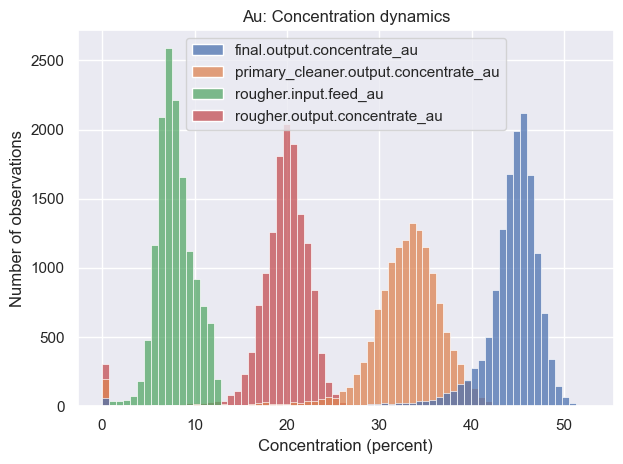

In [35]:
# Plotting gold concentration
plot_concentration_dynamics(
    data=gold_recovery_train, chemical_element_name="Au", hist_bins_number=70
)

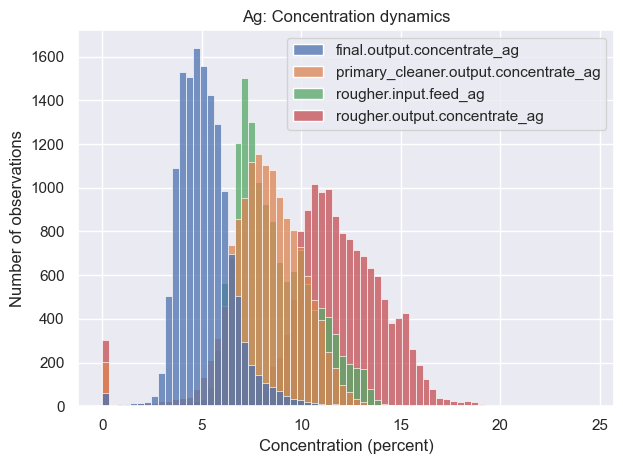

In [36]:
# Plotting silver concentration
plot_concentration_dynamics(
    data=gold_recovery_train, chemical_element_name="Ag", hist_bins_number=70
)

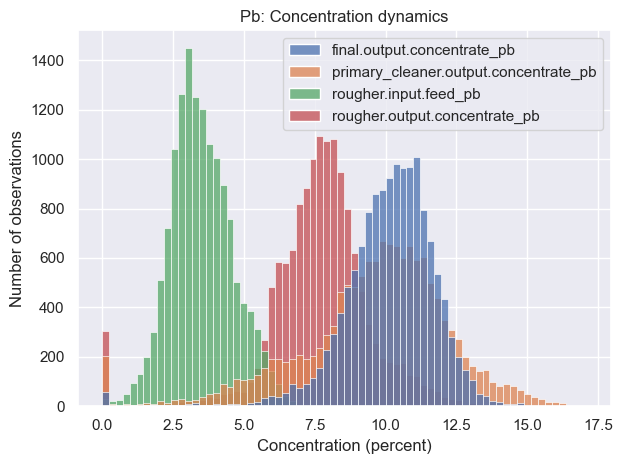

In [37]:
# Plotting lead concentration
plot_concentration_dynamics(
    data=gold_recovery_train, chemical_element_name="Pb", hist_bins_number=70
)

We can see that as the purification stages go through, the concentration of gold increases, which is the meaning of purifying gold-bearing ore. Next, let's look at silver: its concentration decreases with each purification stage. As far as lead is concerned, it represents a byproduct of chemical reaction and that is precisely why we see its concentration moderately increasing.

### Comparing feed sizes

Now, let's compare the distributions of the size of input materials granules, the data on which is contained in `rougher.input.feed_size` column. Hence, let's look at the distribution of values on the histograms for training and test sets.

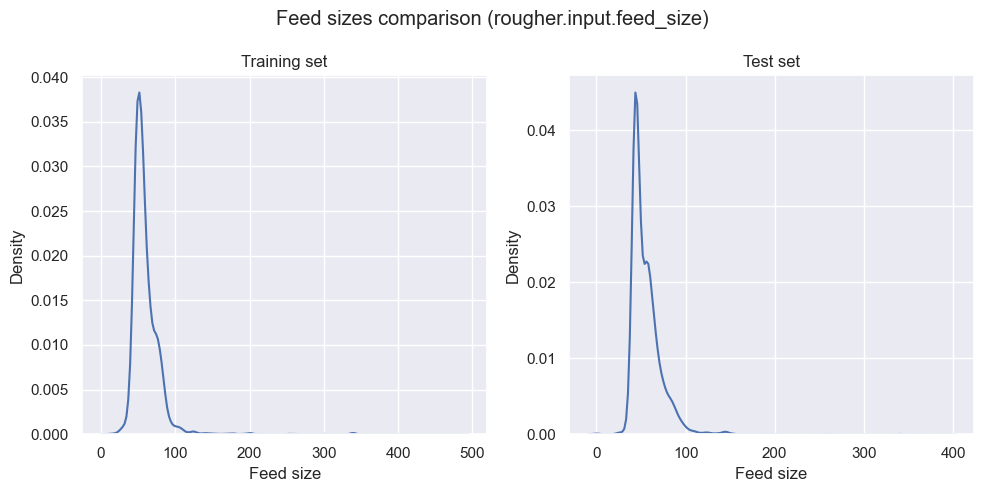

In [38]:
# Comparing feed sizes distributions
feed_size_column_name = "rougher.input.feed_size"

fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5 * 1))
plt.suptitle(f"Feed sizes comparison ({feed_size_column_name})")

sns.kdeplot(data=gold_recovery_train, x=feed_size_column_name, ax=axes[0])
axes[0].set_title("Training set")
axes[0].set_xlabel("Feed size")
axes[0].set_ylabel("Density")

sns.kdeplot(data=gold_recovery_test, x=feed_size_column_name, ax=axes[1])
axes[1].set_title("Test set")
axes[1].set_xlabel("Feed size")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

It can be seen that the histograms are similar, which is a good sign, because the estimates of the models will be more correct and accurate. Let's compare the distribution data in more detail and calculate descriptive statistics for each set using the `describe()` method.

In [39]:
stats_train = gold_recovery_train[feed_size_column_name].describe()
stats_test = gold_recovery_test[feed_size_column_name].describe()

stats_df = pd.concat([stats_train, stats_test], axis=1)
stats_df.columns = ["gold_recovery_train", "gold_recovery_test"]
stats_df

,gold_recovery_train,gold_recovery_test
count,14149.000000,5290.000000
mean,60.239856,55.952754
std,23.005310,19.080334
min,9.659576,0.046369
25%,48.966751,43.906504
50%,55.269784,50.846843
75%,66.007526,62.451165
max,484.967466,392.494040


We see that the values of most descriptive statistics are quite close to each other, which again proves the similarity of these two distributions.

### Total concentration analysis

Now let's look at the total concentration of all elements available on the histograms. To begin with, we will create new columns in the training data, where we will sum up all the available chemical elements and save the results in the appropriate columns.

In [40]:
# Computing total concentration (input)
gold_recovery_train["rougher.input.feed_total"] = (
    gold_recovery_train["rougher.input.feed_au"]
    + gold_recovery_train["rougher.input.feed_ag"]
    + gold_recovery_train["rougher.input.feed_pb"]
    + gold_recovery_train["rougher.input.feed_sol"]
)

# Computing total concentration (rougher)
gold_recovery_train["rougher.output.concentrate_total"] = (
    gold_recovery_train["rougher.output.concentrate_au"]
    + gold_recovery_train["rougher.output.concentrate_ag"]
    + gold_recovery_train["rougher.output.concentrate_pb"]
    + gold_recovery_train["rougher.output.concentrate_sol"]
)

# Computing total concentration (final)
gold_recovery_train["final.output.concentrate_total"] = (
    gold_recovery_train["final.output.concentrate_au"]
    + gold_recovery_train["final.output.concentrate_ag"]
    + gold_recovery_train["final.output.concentrate_pb"]
    + gold_recovery_train["final.output.concentrate_sol"]
)

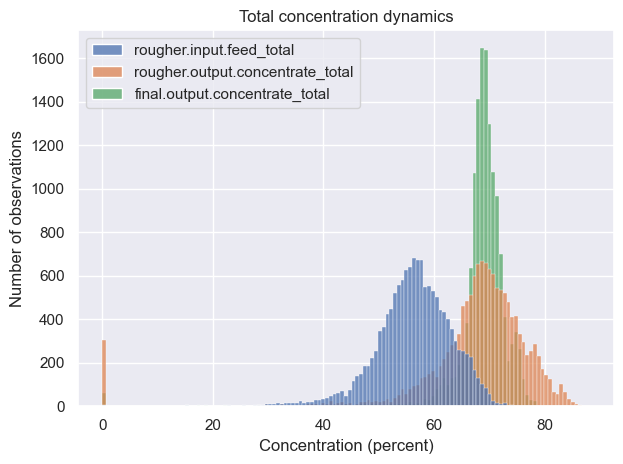

In [41]:
# Filtering data
gold_recovery_train_total = gold_recovery_train.loc[
    :, (gold_recovery_train.columns.str.endswith("total"))
]

# Plotting histograms
total_histplot = sns.histplot(data=gold_recovery_train_total)
total_histplot.set(
    title="Total concentration dynamics",
    xlabel="Concentration (percent)",
    ylabel="Number of observations",
)
plt.tight_layout()
plt.show()

The graph shows that as we move through the purification stages, the distribution of the total concentration of substances becomes narrower, which means that the concentration increases and eventually takes higher values in a narrower region.

### Anomalies analysis

When we plot the histograms on the total concentration, we notice a small bin noticeable in the area of zero values. Such values may represent anomalies, because the total concentration should grow throughout the entire technological process. Let's try to find such values in the data.

In [42]:
anomalies_train = gold_recovery_train_total[
    (gold_recovery_train_total["rougher.input.feed_total"] == 0)
    | (gold_recovery_train_total["rougher.output.concentrate_total"] == 0)
    | (gold_recovery_train_total["final.output.concentrate_total"] == 0)
]
anomalies_train

,rougher.input.feed_total,rougher.output.concentrate_total,final.output.concentrate_total
date,,,
2016-01-16 21:00:00,58.602038,0.0,66.175996
2016-01-16 22:00:00,59.921613,0.0,66.794250
2016-01-16 23:00:00,57.269041,0.0,67.572604
2016-01-17 00:00:00,25.352358,0.0,65.598903
2016-01-17 02:00:00,40.721375,0.0,63.445359
...,...,...,...
2018-02-11 23:59:59,58.106496,0.0,70.703344
2018-02-12 00:59:59,59.500740,0.0,70.814703
2018-02-12 01:59:59,60.129638,0.0,71.329178


We see that there are indeed anomalies in `rougher.output.concentrate_total` column as well as in `final.output_concentrate_total` column (not visible). In fact, the bins for these two columns were visible on the graph above in the area of zero values. Let's try to delete these rows from the training set.

In [43]:
print("Training set size (with anomalies): {:,}".format(gold_recovery_train.shape[0]))
# Deleting anomalies
gold_recovery_train.drop(anomalies_train.index, inplace=True)
print(
    "Training set size (without anomalies): {:,}".format(gold_recovery_train.shape[0])
)
print("Anomalies found and deleted: {}".format(anomalies_train.index.shape[0]))

Training set size (with anomalies): 14,149
Training set size (without anomalies): 13,795
Anomalies found and deleted: 354


We have managed to clean the data from anomalies successfully. Let's delete columns with total concentration from data and move on to modeling.

In [44]:
gold_recovery_train = gold_recovery_train.drop(
    gold_recovery_train.columns[gold_recovery_train.columns.str.endswith("total")],
    axis=1,
)

# Verifying the correctness of columns deletion
assert (
    gold_recovery_train.columns.shape[0] == gold_recovery_full.columns.shape[0]
), "Number of columns discrepancy"

**Conclusion**

At this stage, exploratory data analysis of the data was carried out, during which we studied the concentration of the main chemical elements involved in the purification process (gold, silver, lead) at various stages, analyzed the size of granules in both training and test samples, and also considered changes in the stages of the total concentration. The analysis helped to identify a number of abnormally low values, which we managed to get rid of.

## Modelling

### Final data preparation

Before proceeding to the training models, we need to make sure that the features in the training and test sets match. Earlier it was noticed that this is not the case, since some features cannot yet be calculated and measured. Therefore, we will filter the training data set so that it has the same columns as the test set does.

In [45]:
# Filtering training set
gold_recovery_train = gold_recovery_train[gold_recovery_test.columns]

# Verifying the correctness of changes made
assert (
    np.mean(gold_recovery_train.columns == gold_recovery_test.columns) == 1
), "Columns differ in two sets"

We did not get any errors so we can be sure that two sets are now homogeneous. Lastly, let's separate features from targets.

In [46]:
# Separating features from targets in the training set
features_train = gold_recovery_train.drop(
    [target_name_rougher, target_name_final], axis=1
)
target_train_rougher = gold_recovery_train[target_name_rougher]
target_train_final = gold_recovery_train[target_name_final]

# Separating features from targets in the test set
features_test = gold_recovery_test.drop(
    [target_name_rougher, target_name_final], axis=1
)
target_test_rougher = gold_recovery_test[target_name_rougher]
target_test_final = gold_recovery_test[target_name_final]

### *sMAPE* metric

We need to focus on the target metric in more detail. Since we will consider the *sMAPE* metric, we will write a function that will perform the calculation. The metric is calculated as follows:

$$
sMAPE =  \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{0.5 \times (|y_i| + |\hat{y}_i|)} \times 100 \%,
$$

where $y_i$ is real target data, $\hat{y}_i$ - predicted value for a target and $N$ - number of observations. The overall value of  $sMAPE$ will consist of two computed *sMAPE* metrics for `rougher` and `final`:

$$
sMAPE_{overall} = 0.25 \times sMAPE_{rougher} + 0.75 \times sMAPE_{final}
$$

Thus, we will define a function, which we will call `smape()` and which will calculate the value of this metric for certain real target values and corresponding predictions. Additionally, we will create a second function called `smape_overall()` for computing the value of the final target metric.

In [47]:
def smape(y_real: pd.Series, y_pred: pd.Series) -> float:
    """Calculates the value of sMAPE metric.

    Args:
        y_real: Real target data.
        y_pred: Predicted values of target.

    Returns:
        Floating point number being the value
        of sMAPE metric.
    """
    smape = (
        np.mean(np.abs(y_real - y_pred) / ((np.abs(y_real) + np.abs(y_pred)) / 2)) * 100
    )

    return smape

In [48]:
def smape_overall(
    smape_rougher: float,
    smape_final: float,
    weight_rougher: float = 0.25,
    weight_final: float = 0.75,
) -> float:
    """Computes the value of the final
    sMAPE metric.

    Args:
        smape_rougher: Value of sMAPE computed for
            rougher target.
        smape_final: Value of sMAPE computed for
            final target.
        weight_rougher: Weight given to sMAPE computed
            for rougher target. [default: {0.25}]
        weight_final: Weight given to sMAPE computed
            for final target. [default: {0.75}]

    Returns:
        Floating point value of the overall sMAPE metric.
    """
    smape_overall = np.sum([weight_rougher * smape_rougher, weight_final * smape_final])

    return smape_overall

Now let's move on to the actual modeling process. We will consider three regression models:

* *Linear Regression*
* *Decision Tree Regressor*
* *Random Forest Regressor*

We will train models based on cross-validation, where our `smape_score()` function will be used as the target metric. However, in order to correctly use the `sklearn` cross-validation, we need to define a scorer function that can be set using the `make_scorer()` function. Moreover, when defining it, we specify `greater_is_better=False`, since *sMAPE* is essentially a loss that should take as low values as possible.

In [49]:
# Defining a scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

Let's consider each of the three models, where for a Decision Tree and a Random Forest we will conduct a small series of hyperparameter tunings.

### *LinearRegression*

In [50]:
lin_reg_model = LinearRegression()

# Cross-validation for "rougher" target
smape_scores_rougher = cross_val_score(
    lin_reg_model,
    features_train,
    target_train_rougher,
    cv=CV_FOLDS,
    scoring=smape_scorer,
)
# Cross-validation for "final" target
smape_scores_final = cross_val_score(
    lin_reg_model, features_train, target_train_final, cv=CV_FOLDS, scoring=smape_scorer
)

# Computing average scores
smape_score_rougher, smape_score_final = np.mean(smape_scores_rougher), np.mean(
    smape_scores_final
)

# Computing overall sMAPE
smape_score_overall = smape_overall(
    smape_rougher=smape_score_rougher, smape_final=smape_score_final
)
smape_LR = np.abs(smape_score_overall)

print("Model: {}".format(lin_reg_model))
print("sMAPE: {:.2f}%".format(smape_LR))

Model: LinearRegression()
sMAPE: 12.64%


### *DecisionTreeRegressor*

In [51]:
# Hyperparameter tuning for DecisionTree
best_smape_DTR = np.inf
best_model_DTR = None
for depth in range(1, MAX_DEPTH + 1):
    decision_tree_model = DecisionTreeRegressor(
        random_state=RANDOM_STATE, max_depth=depth
    )

    smape_scores_rougher = cross_val_score(
        decision_tree_model,
        features_train,
        target_train_rougher,
        cv=CV_FOLDS,
        scoring=smape_scorer,
    )
    smape_scores_final = cross_val_score(
        decision_tree_model,
        features_train,
        target_train_final,
        cv=CV_FOLDS,
        scoring=smape_scorer,
    )

    smape_score_rougher, smape_score_final = np.mean(smape_scores_rougher), np.mean(
        smape_scores_final
    )

    smape_score_overall = smape_overall(
        smape_rougher=smape_score_rougher, smape_final=smape_score_final
    )

    smape_score_overall = np.abs(smape_score_overall)

    # Making a decision about the best model
    if smape_score_overall < best_smape_DTR:
        best_smape_DTR = smape_score_overall
        best_model_DTR = decision_tree_model

print("Best model (Decision Tree): {}".format(best_model_DTR))
print("Best sMAPE (Decision Tree): {:.2f}%".format(best_smape_DTR))

Best model (Decision Tree): DecisionTreeRegressor(max_depth=1, random_state=12345)
Best sMAPE (Decision Tree): 10.04%


### *RandomForestRegressor*

In [52]:
# Hyperparameter tuning for Random Forest
best_smape_RFR = np.inf
best_model_RFR = None
for est in range(
    FOREST_SIZE_START, FOREST_SIZE_END + FOREST_SIZE_STEP, FOREST_SIZE_STEP
):
    for depth in range(1, FOREST_MAX_DEPTH + 1):
        random_forest_model = RandomForestRegressor(
            random_state=RANDOM_STATE, n_estimators=est, max_depth=depth
        )

        smape_scores_rougher = cross_val_score(
            random_forest_model,
            features_train,
            target_train_rougher,
            cv=CV_FOLDS,
            scoring=smape_scorer,
        )
        smape_scores_final = cross_val_score(
            random_forest_model,
            features_train,
            target_train_final,
            cv=CV_FOLDS,
            scoring=smape_scorer,
        )

        smape_score_rougher, smape_score_final = np.mean(smape_scores_rougher), np.mean(
            smape_scores_final
        )

        smape_score_overall = smape_overall(
            smape_rougher=smape_score_rougher, smape_final=smape_score_final
        )

        smape_score_overall = np.abs(smape_score_overall)

        if smape_score_overall < best_smape_RFR:
            best_smape_RFR = smape_score_overall
            best_model_RFR = random_forest_model

print("Best model (Random Forest): {}".format(best_model_RFR))
print("Best sMAPE (Random Forest): {:.2f}%".format(best_smape_RFR))

Best model (Random Forest): RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)
Best sMAPE (Random Forest): 9.76%


### Model comparison

Now, let's compare the results of the modeling and create a table summarizing the results.

In [53]:
# Creating a comparison table
cols = {
    "model": [
        type(lin_reg_model).__name__,
        type(decision_tree_model).__name__,
        type(random_forest_model).__name__,
    ],
    "smape_score_overall": [smape_LR, best_smape_DTR, best_smape_RFR],
}

compare_df = pd.DataFrame(data=cols).sort_values(by="smape_score_overall").round(2)
display(compare_df)

# Making a decision about the final model
best_model = None
if compare_df["model"].iloc[0] == type(lin_reg_model).__name__:
    best_model = lin_reg_model
    best_smape = smape_lin_reg
elif compare_df["model"].iloc[0] == type(best_model_DTR).__name__:
    best_model = best_model_DTR
    best_smape = best_smape_DTR
else:
    best_model = best_model_RFR
    best_smape = best_smape_RFR

print("Final model: {}".format(best_model))
print("Final sMAPE: {:.2f}%".format(best_smape))

,model,smape_score_overall
2,RandomForestRegressor,9.76
1,DecisionTreeRegressor,10.04
0,LinearRegression,12.64


Final model: RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)
Final sMAPE: 9.76%


The results show that the best model proves to be a Random Forest with 20 trees with depth of 2 each. The model's value of *sMAPE* metric is 9.76%.

## Testing

Now, let's test the model we chose and compute the target metric on the test set.

In [54]:
# Computing rougher sMAPE
best_model.fit(features_train, target_train_rougher)
predictions_test_rougher = best_model.predict(features_test)
smape_score_test_rougher = smape(
    y_real=target_test_rougher, y_pred=predictions_test_rougher
)

# Computing final sMAPE
best_model.fit(features_train, target_train_final)
predictions_test_final = best_model.predict(features_test)
smape_score_test_final = smape(y_real=target_test_final, y_pred=predictions_test_final)

# Computing overall sMAPE
smape_score_test_overall = smape_overall(
    smape_rougher=smape_score_test_rougher, smape_final=smape_score_test_final
)

# Printing testing results
print("Tested model: {}".format(best_model))
print("Test sMAPE: {:.2f}%".format(smape_score_test_overall))

Tested model: RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345)
Test sMAPE: 9.07%


We see that the value of the metric decreased somewhat on the test set but that is expected. Additionally, let's compare the results of the model with constant model which we can configure using `DummyRegressor()`. In this case, we will compare test predictions with median target values.

In [55]:
# Comparison
dummy_reg_model = DummyRegressor(strategy="median")

dummy_reg_model.fit(features_train, target_train_rougher)
predictions_dummy_rougher = dummy_reg_model.predict(features_test)
smape_score_dummy_rougher = smape(
    y_real=target_test_rougher, y_pred=predictions_dummy_rougher
)

dummy_reg_model.fit(features_train, target_train_final)
predictions_dummy_final = dummy_reg_model.predict(features_test)
smape_score_dummy_final = smape(
    y_real=target_test_final, y_pred=predictions_dummy_final
)

smape_score_dummy_overall = smape_overall(
    smape_rougher=smape_score_dummy_rougher, smape_final=smape_score_dummy_final
)

# Verifying the adequacy of the model
assert smape_score_dummy_overall > smape_score_test_overall, "Model is inadequate"

print("Model: {}".format(dummy_reg_model))
print("Dummy sMAPE: {:.2f}%".format(smape_score_dummy_overall))

Model: DummyRegressor(strategy='median')
Dummy sMAPE: 9.44%


## General conclusion

Within the framework of this project, data on the purification of gold-bearing ore were analyzed, as a result of which a data overview, preprocessing, as well as exploratory data analysis were carried out. Furthermore, we have built several models in order to predict the recovery rate of gold. According to the modelling results, the best model showing the smallest values of the target metric *sMAPE* is a Random Forest model with 20 trees with a depth of 2.